# Import Model Detector dependencies

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import pathlib
import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


# Helper functions

In [3]:
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
# PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
# PATH_TO_MODEL_DIR='C:\\Users\\Roman\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR='E:\\Study\\Simulation-Based_Testing_Autonomous_Cars\\seminar-on-testing-self-driving-cars-wise-20-21-project\\exported-models'

In [4]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
# PATH_TO_LABELS = download_labels(LABEL_FILENAME)
# PATH_TO_LABELS='C:\\Users\\Roman\\.keras\\datasets\\mscoco_label_map.pbtxt'
PATH_TO_LABELS='E:\\Study\\Simulation-Based_Testing_Autonomous_Cars\\seminar-on-testing-self-driving-cars-wise-20-21-project\\exported-models\\label_map.pbtxt'

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load Model

In [6]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL);

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 28.936643838882446 seconds


# Load label map data

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

# Define detection functions

In [8]:
def detect_image(image, image_detections):
    
    image_np = load_image_into_numpy_array(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
    return { 'base_image': image_np, 'image_with_detections': image_np_with_detections, 'data': detections}

In [ ]:
score_thresh = 0.35

In [10]:
def plot_detected_object(image_np_with_detections, detections, category_index, min_score_thresh = score_thresh):
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=min_score_thresh,
      agnostic_mode=False)
    plt.figure()
    plt.imshow(image_np_with_detections)

In [11]:
def get_detected_classes(scores, classes, boxes, min_score_thresh = score_thresh, max_boxes_to_draw = 20):
    predicted_classes=[]
    for i in range(min(max_boxes_to_draw, boxes.shape[0])):
        if scores is None or scores[i] > min_score_thresh:
            if classes[i] in category_index.keys():
                class_name = category_index[classes[i]]['name']
                predicted_classes.append(class_name)
    return predicted_classes

# Define BEAMNG functions

In [12]:
import os
from pathlib import Path
from os.path import join

In [13]:
def handle_driving_command(vehicle, command):
    print(command)
    if (command == 'stop'):
        vehicle.ai_set_mode('stopping')
        vehicle.ai_set_speed(0.1)
        return True
        #vehicle.control(throttle = 0, brake = 0)
    if (command == 'go'):
        vehicle.ai_set_mode('random')
        vehicle.ai_set_speed(15)
        return True
    if (command == 'continue'):
        return True

In [14]:
def generate_control_command(traffic_light_color):
    if (traffic_light_color == 'red'):
        return 'stop'
    if (traffic_light_color == 'green'):
        return 'go'

In [15]:
def get_traffic_light_color(detection):
    detected_classes = get_detected_classes(
        detection['data']['detection_scores'],
        detection['data']['detection_classes'], 
        detection['data']['detection_boxes'])
    if (len(detected_classes) > 0):
        traffic_light_color = detected_classes[0]
        return traffic_light_color
    return None

In [16]:
def get_driving_instruction(vehicle, detection, traffic_light_color):
    return generate_control_command(traffic_light_color)

In [17]:
def create_setup():
    beamng = BeamNGpy('localhost', 64256, home='E:/BeamNG.research')
    scenario = Scenario('urban', 'urban_3612')
    scenario.path=Path(join(os.environ['BNG_HOME'], "levels", "urban", "scenarios"))
    return beamng, scenario;

In [18]:
def run_beamng(beamng, scenario):
    bng = beamng.open(launch=True)
    vehicle = Vehicle('ego', model='etk800', licence='RED', color='Red')
    timer = Timer()
    pos = (-0.3, 1, 1.0)
    direction = (0, 1, 0)
    fov = 90
    resolution = (512, 512)
    front_camera = Camera(pos, direction, fov, resolution,
                              colour=True, depth=True, annotation=True)
    vehicle.attach_sensor('front_camera', front_camera)
    bng.load_scenario(scenario)
    bng.spawn_vehicle(vehicle, pos=(2.0, -4.0, 0), rot=None, rot_quat=(0, 1, 0, 0))
    vehicle.ai_set_speed(15)
    return bng, vehicle

In [19]:
def stop_bng(bng):
    bng.close()

In [20]:
def run_steps(steps = 60):
    bng.step(steps)

In [21]:
def get_image(bng, vehicle):
    sensors = bng.poll_sensors(vehicle)
    return sensors['front_camera']['colour'].convert('RGB')

In [22]:
def run_iteration(bng, vehicle, object_coordinates, passing_traffic_light, last_known_color, violations):
    image = get_image(bng, vehicle)
    vehicle.update_vehicle()
    vehicle_position = vehicle.state['pos']
    _, min_distance_pair_point_2, min_distance, index_of_nearest_point = get_closest_pair_of_points([vehicle_position], object_coordinates)
    if (min_distance < 5 and passing_traffic_light == False):
        passing_traffic_light = True
    elif (min_distance > 5 and passing_traffic_light == True):
        passing_traffic_light = False
        if(last_known_color == "red"):
            violations.append({'object': min_distance_pair_point_2, 'vehicle_position': vehicle_position, 'distance': min_distance, 'last_known_color': last_known_color})
    detection = detect_image(image, [])
    traffic_light_color = get_traffic_light_color(detection)
    if (traffic_light_color != None):
        last_known_color = traffic_light_color
#     driving_instruction = get_driving_instruction(vehicle, detection)
#     print(driving_instruction)
#     handle_driving_command(vehicle, driving_instruction)
    run_steps(10)
    return passing_traffic_light, last_known_color, violations

In [23]:
def get_coordinates(position):
    return {'x': position[0],'y': position[1], 'z': position[2]}

In [24]:
def get_distance(object_position_1, object_position_2):
    return np.linalg.norm(object_position_1-object_position_2)

In [25]:
def construct_node(coordinates, previous_time):
     return {
            'x': coordinates['x'],
            'y':  coordinates['y'],
            'z': orig[2],
            #  Calculate timestamps for each node such that the speed between
            #  points has a sinusoidal variance to it.
            't': previous_time + 10,
            }   

In [26]:
def transform_node_to_np_array(node):
    return np.array([node['x'], node['y'], node['z']])
    

In [27]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

def get_closest_pair_of_points(point_list_1,
                           point_list_2):
    """
    Determine the two points from two disjoint lists of points that are closest to 
    each other and the distance between them.

    Args:
        point_list_1: First list of points.
        point_list_2: Second list of points.

    Returns:
        Two points that make the closest distance and the distance between them.
    """
    indeces_of_closest_point_in_list_2, distances = pairwise_distances_argmin_min(point_list_1, point_list_2)

    # Get index of a point pair that makes the smallest distance.
    min_distance_pair_index = np.argmin(distances)

    # Get the two points that make this smallest distance.
    min_distance_pair_point_1 = point_list_1[min_distance_pair_index]
    min_distance_pair_point_2 = point_list_2[indeces_of_closest_point_in_list_2[min_distance_pair_index]]

    min_distance = distances[min_distance_pair_index]

    return min_distance_pair_point_1, min_distance_pair_point_2, min_distance, indeces_of_closest_point_in_list_2[min_distance_pair_index]

# Run BEAMNG

In [28]:
images = []
detections = []

In [29]:
%matplotlib
import mmap
import random
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from time import sleep
import numpy as np
from beamngpy import BeamNGpy, Scenario, Vehicle, setup_logging
from beamngpy.sensors import Camera, Timer, Lidar,Electrics
import math

Using matplotlib backend: Qt5Agg


In [30]:
beamng, scenario = create_setup()

In [31]:
bng, vehicle = run_beamng(beamng, scenario)

In [32]:
bng.start_scenario()

In [33]:
bng.pause()

In [34]:
last_known_color = None
passing_traffic_light = False
violations = []

In [35]:
object_coordinates = np.array([])
for static_object in scenario.find_static_objects():
    coordinates = get_coordinates(static_object.pos)
    if (coordinates['x'] != 0 and coordinates['y'] != 0 and coordinates['z'] == 0):
     
        np_node = [transform_node_to_np_array(coordinates)]
        if (len(object_coordinates) == 0):
            object_coordinates = np_node
        else:
            object_coordinates = np.concatenate((object_coordinates,np_node),axis=0) 

In [36]:
# nodes = np.array([[0,0,0]])
# orig = (2.0,-4.0,0)
# script = [{'x':2.0, 'y': -4.0, 'z':0, 't': 5}]

# points = [[0,0,0]]
# point_colors = [[0, 0.17364817766693033, 0, 0.1]]
# spheres = [[0,0,0]]
# sphere_colors = [[0, 0.17364817766693033, 0, 0.1]]
# i = 10
# for static_object in scenario.find_static_objects():
#     coordinates = get_coordinates(static_object.pos)
#     if (coordinates['x'] != 0 and coordinates['y'] != 0):
#         distance = get_distance(nodes[-1], transform_node_to_np_array(coordinates))
#         if (distance > 5):
#             nodes = np.append(nodes, [transform_node_to_np_array(coordinates)], axis = 0)
#             node = construct_node(coordinates, i)
#             script.append(node)
#             points.append([node['x'], node['y'], node['z']])
#             point_colors.append([0, np.sin(np.radians(i)), 0, 0.1])
#             spheres.append([node['x'], node['y'], node['z'], np.abs(np.sin(np.radians(i))) * 0.25])
#             sphere_colors.append([np.sin(np.radians(i)), 0, 0, 0.8])
#             i += 20


In [37]:
# run_iteration(bng, vehicle, object_coordinates, passing_traffic_light, last_known_color, violations)

In [38]:
print(last_known_color)

None


In [39]:
for _ in range(120):
    passing_traffic_light, last_known_color, violations = run_iteration(bng, vehicle, object_coordinates, passing_traffic_light, last_known_color, violations)

In [40]:
print(violations)

[{'object': array([57.741436  , 75.01264191,  0.        ]), 'vehicle_position': [61.12176513671875, 79.24068450927734, 0.22844043374061584], 'distance': 5.418039712095311, 'last_known_color': 'red'}, {'object': array([241.35803223, -23.58342171,   0.        ]), 'vehicle_position': [242.10301208496094, -16.095888137817383, 0.194038987159729], 'distance': 7.527005053133351, 'last_known_color': 'red'}]


In [41]:
bng.close()

# Visualize detections

In [ ]:
# # plt.ion()
# for detection in detections:
# #     viz_utils.visualize_boxes_and_labels_on_image_array(
# #       detection['image_with_detections'],
# #       detection['data']['detection_boxes'],
# #       detection['data']['detection_classes'],
# #       detection['data']['detection_scores'],
# #       category_index,
# #       use_normalized_coordinates=True,
# #       max_boxes_to_draw=20,
# #       min_score_thresh=.30,
# #       agnostic_mode=False)
#     detected_classes = get_detected_classes( 
#         detection['data']['detection_scores'],
#         detection['data']['detection_classes'], 
#         detection['data']['detection_boxes'])
#     print(detected_classes)
#     if (len(detected_classes) > 0):
#         plot_detected_object(detection['image_with_detections'], detection['data'], category_index)
# plt.show()


# Run Detector

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings



# plt.ion()
# for image in images:

#     image_np = load_image_into_numpy_array(image)

#     # Flip horizontally
#     # image_np = np.fliplr(image_np).copy()

#     # image_np = np.tile(
#     #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

#     # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
#     input_tensor = tf.convert_to_tensor(image_np)
#     # The model expects a batch of images, so add an axis with `tf.newaxis`.
#     input_tensor = input_tensor[tf.newaxis, ...]

#     # input_tensor = np.expand_dims(image_np, 0)
#     detections = detect_fn(input_tensor)

#     # All outputs are batches tensors.
#     # Convert to numpy arrays, and take index [0] to remove the batch dimension.
#     # We're only interested in the first num_detections.
#     num_detections = int(detections.pop('num_detections'))
#     detections = {key: value[0, :num_detections].numpy()
#                    for key, value in detections.items()}
#     detections['num_detections'] = num_detections

#     # detection_classes should be ints.
#     detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

#     image_np_with_detections = image_np.copy()

#     viz_utils.visualize_boxes_and_labels_on_image_array(
#           image_np_with_detections,
#           detections['detection_boxes'],
#           detections['detection_classes'],
#           detections['detection_scores'],
#           category_index,
#           use_normalized_coordinates=True,
#           max_boxes_to_draw=20,
#           min_score_thresh=.30,
#           agnostic_mode=False)

#     plt.figure(figsize = (12,8))
#     plt.imshow(image_np_with_detections)
#     print('Done')
# plt.show()

# # sphinx_gallery_thumbnail_number = 2

# Evaluation

In [27]:
image = Image.open('E:\\Study\\driving-object-detection\\images\\green_bng_2.png')
images = [image]

Done


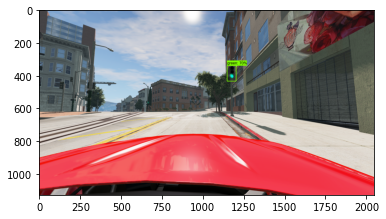

In [28]:
# image_np = load_image_into_numpy_array(image)

# # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
# input_tensor = tf.convert_to_tensor(image_np)
# # The model expects a batch of images, so add an axis with `tf.newaxis`.
# input_tensor = input_tensor[tf.newaxis, ...]

# # input_tensor = np.expand_dims(image_np, 0)
# detections = detect_fn(input_tensor)

# # All outputs are batches tensors.
# # Convert to numpy arrays, and take index [0] to remove the batch dimension.
# # We're only interested in the first num_detections.
# num_detections = int(detections.pop('num_detections'))
# detections = {key: value[0, :num_detections].numpy()
#                for key, value in detections.items()}
# detections['num_detections'] = num_detections

# # detection_classes should be ints.
# detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# image_np_with_detections = image_np.copy()

# viz_utils.visualize_boxes_and_labels_on_image_array(
#       image_np_with_detections,
#       detections['detection_boxes'],
#       detections['detection_classes'],
#       detections['detection_scores'],
#       category_index,
#       use_normalized_coordinates=True,
#       max_boxes_to_draw=200,
#       min_score_thresh=.30,
#       agnostic_mode=False)

# plt.figure()
# plt.imshow(image_np_with_detections)
# print('Done')
# # plt.show()

Done


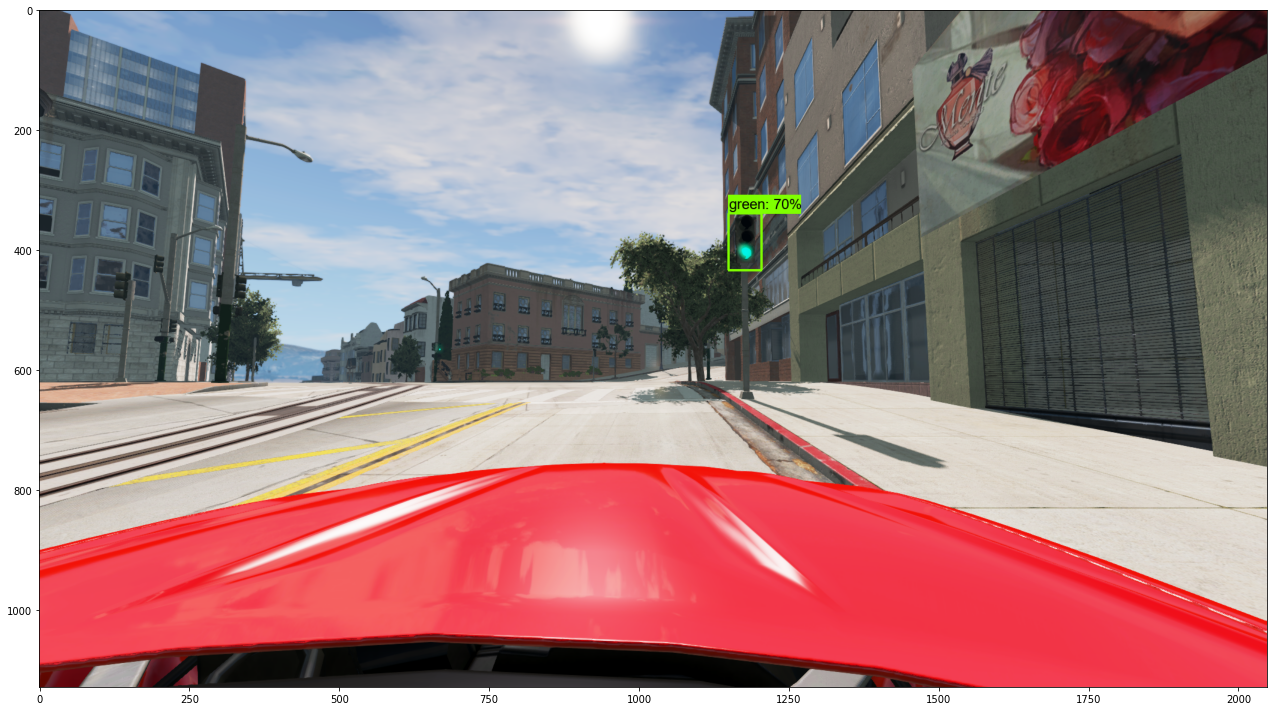

In [29]:
for image in images:

    image_np = load_image_into_numpy_array(image)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure(figsize = (22,14))
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()